In [1]:
import sys

In [2]:
sys.path.insert(0, '../')

In [20]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch_geometric.data import Batch as gBatch
from torch_geometric.data import DataListLoader as gDataLoader
import glob
import numpy as np
import datasets as ds
from sampling_functions import bspline
from time import time
import os

In [4]:
np.random.seed(10)

In [9]:
import configparser

In [10]:
exp = '../paper_runs/sdec_nodropout_loss_nll-data_hcp20_gt20mm_resampled16_fs8000_balanced_sampling_1'

In [11]:
var = 'HCP20'
cfg_parser = configparser.ConfigParser()
cfg_parser.read(exp + '/config.txt')
cfg = {}
cfg[var] = {}
for name, value in cfg_parser.items('DEFAULT'):
    if value == 'y':
        value = True
    elif value == 'n':
        value = False
    cfg[var][name] = value
for name, value in cfg_parser.items(var):
    if value == 'y':
        value = True
    elif value == 'n':
        value = False
    cfg[var][name] = value
cfg = cfg[var]
cfg['weights_path'] = ''
cfg['exp_path'] = exp
cfg['with_gt'] = False

In [12]:
# fn = '/home/pietro/datasets/TractSeg_new/ground_truth_trk/sub-599469/sub-599469_var-GT_AF_left.trk'
# fn = '/home/pietro/datasets/TractSeg_full/downsampled_tractograms/sub-599469/All_500000.trk'
# fn = '/home/pietro/src/tractconverter/599469_AF_left_warped_MNI.trk'
# fn = '/home/pietro/src/tractconverter/599469_all_500000_MNI.trk'
# fn = '/home/pietro/datasets/ExTractor_PRIVATE/derivatives/streamlines_resampled_16_gt20mm/sub-t0337/sub-t0337_var-GIN_full_tract.trk'
# cfg['dataset_dir'] = '/home/pietro/datasets/ExTractor_PRIVATE/derivatives/streamlines_resampled_16_gt20mm'
cfg['dataset_dir'] = '/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16'

In [13]:
sub_list = '../data/sub_list_AFQ.txt'

In [14]:
cfg['fixed_size'] = 40000

In [8]:
class AFQDataset(gDataset):
    def __init__(self,
                 sub_file,
                 root_dir,
                 same_size=True,
                 transform=None,
                 distance=None,
                 with_gt=False,
                 return_edges=False,
                 split_obj=True,
                 train=False,
                 standardize=False,
                 centering=False,
                 labels_dir=None,
                 permute=False):
        """
        Args:
            root_dir (string): root directory of the dataset.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        with open(sub_file) as f:
            subjects = [s.strip() for s in f.readlines()]
        self.subjects = subjects
        self.transform = transform
        self.distance = distance
        self.with_gt = with_gt
        self.return_edges = return_edges
        self.train = train
        self.same_size = same_size
        self.standardize = standardize
        self.centering = centering
        self.permute = permute
        if train:
            split_obj=False
        if split_obj:
            self.remaining = [[] for _ in range(len(subjects))]
        self.split_obj = split_obj
        if with_gt:
            self.labels = []
            for sub in subjects:
                label_sub_dir = os.path.join(self.root_dir.rsplit('/',1)[0], labels_dir ,'sub-%s' % sub)
                label_file = os.path.join(label_sub_dir, 'sub-%s_var-GIN_labels.npy' % (sub))
                self.labels.append(np.load(label_file))

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        #print(self.subjects[idx])
        #t0 = time.time()
        item = self.getitem(idx)
        #print('get item time: {}'.format(time.time()-t0))
        return item

    def getitem(self, idx):
        sub = self.subjects[idx]
        #t0 = time.time()
        sub_dir = os.path.join(self.root_dir, 'sub-%s' % sub)
        T_file = os.path.join(sub_dir, 'sub-%s_tract_MNI16.trk' % (sub))
        T = nib.streamlines.load(T_file, lazy_load=True)
        #print('\tload lazy T %f' % (time.time()-t0))
        #t0 = time.time()
        gt = self.labels[idx] if self.with_gt else None
        #print('\tload gt %f' % (time.time()-t0))
        if self.split_obj:
            if len(self.remaining[idx]) == 0:
                self.remaining[idx] = set(np.arange(T.header['nb_streamlines']))
            sample = {'points': np.array(list(self.remaining[idx]))}
            if self.with_gt:
                sample['gt'] = gt[list(self.remaining[idx])]
        else:
            #sample = {'points': np.arange(T.header['nb_streamlines'])}
            #if self.with_gt:
            #sample['gt'] = gt
            sample = {'points': np.arange(T.header['nb_streamlines']), 'gt': gt}
        #print(sample['name'])

        #t0 = time.time()
        if self.transform:
            sample = self.transform(sample)
        #print('\ttime sampling %f' % (time.time()-t0))

        if self.split_obj:
            self.remaining[idx] -= set(sample['points'])
            sample['obj_idxs'] = sample['points'].copy()
            sample['obj_full_size'] = T.header['nb_streamlines']
            #sample['streamlines'] = T.streamlines

        sample['name'] = T_file.split('/')[-1].rsplit('.', 1)[0]
        sample['dir'] = sub_dir

        n = len(sample['points'])
        #t0 = time.time()
        if self.same_size:
            streams, lengths = load_selected_streamlines_uniform_size(T_file,
                                                    sample['points'].tolist())
            if self.centering:
                streams_centered = streams.reshape(-1, lengths[0], 3)
                streams_centered -= streams_centered.mean(axis=1)[:,None,:]
                streams = streams_centered.reshape(-1,3)
            if self.permute:
                # import ipdb; ipdb.set_trace()
                streams_perm = self.permute_pts(
                    streams.reshape(-1, lengths[0], 3))
                streams = streams_perm.reshape(-1, 3)
        else:
            #streams, _, lengths, _ = load_streamlines(T_file,
            #                                        idxs=sample['points'].tolist(),
            #                                        container='array_flat')
            streams, lengths = load_selected_streamlines(T_file,
                                                    sample['points'].tolist())
            #print('\ttime loading selected streamlines %f' % (time.time()-t0))
            if self.centering:
                streams_centered = self.center_sl_list(
                    np.split(streams, np.cumsum(lengths))[:-1])
                streams = np.vstack(streams_centered)

            if self.permute:
                streams_perm = self.permute_pts(
                    np.split(streams, np.cumsum(lengths))[:-1])
                streams = streams_perm.reshape(-1, 3)
        
        if self.standardize:
            stats_file = glob.glob(sub_dir + '/*_stats.npy')[0]
            mu, sigma, M, m = np.load(stats_file)
            streams = (streams - mu) / sigma



        #t0 = time.time()
        sample['points'] = self.build_graph_sample(streams,
                    lengths,
                    torch.from_numpy(sample['gt']) if self.with_gt else None)
        #sample['tract'] = streamlines
        #print('sample:',sample['points'])
        #print('\ttime building graph %f' % (time.time()-t0))
        return sample

    def center_sl_list(self, sl_list):
        centers = np.array(map(functools.partial(np.mean, axis=0), sl_list))
        return map(np.subtract, sl_list, centers)

    def permute_pts(self, sl_list):
        perm_sl_list = []
        for sl in sl_list:
            perm_idx = torch.randperm(len(sl)).tolist()
            perm_sl_list.append(sl[perm_idx])
        return np.array(perm_sl_list)


    def build_graph_sample(self, streams, lengths, gt=None):
        #t0 = time.time()
        #print('time numpy split %f' % (time.time()-t0))
        ### create graph structure
        #sls_lengths = torch.from_numpy(sls_lengths)
        lengths = torch.from_numpy(lengths).long()
        #print('sls lengths:',sls_lengths)
        batch_vec = torch.arange(len(lengths)).repeat_interleave(lengths)
        batch_slices = torch.cat([torch.tensor([0]), lengths.cumsum(dim=0)])
        slices = batch_slices[1:-1]
        streams = torch.from_numpy(streams)
        l = streams.shape[0]
        graph_sample = gData(x=streams,
                             lengths=lengths,
                             #sls_lengths=sls_lengths,
                             bvec=batch_vec,
                             pos=streams)
        #                     bslices=batch_slices)
        #edges = torch.empty((2, 2*l - 2*n), dtype=torch.long)
        if self.return_edges:
            e1 = set(np.arange(0,l-1)) - set(slices.numpy()-1)
            e2 = set(np.arange(1,l)) - set(slices.numpy())
            edges = torch.tensor([list(e1)+list(e2),list(e2)+list(e1)],
                            dtype=torch.long)
      
            graph_sample['edge_index'] = edges
            num_edges = graph_sample.num_edges
            edge_attr = torch.ones(num_edges,1)
            graph_sample['edge_attr'] = edge_attr
        if self.distance:
            graph_sample = self.distance(graph_sample)
        #if self.self_loops:
        #graph_sample = self.self_loops(graph_sample)
        if gt is not None:
            graph_sample['y'] = gt

        return graph_sample


NameError: name 'gDataset' is not defined

In [119]:
dataset = AFQDataset(sub_list,
                          cfg['dataset_dir'],
                          same_size=cfg['same_size'],
                          transform=transforms.Compose([TestSampling(int(cfg['fixed_size']))]),
                          return_edges=cfg['return_edges'],
                          split_obj=True,
                          train=False)

dataloader = gDataLoader(dataset,
                         batch_size=1,
                         shuffle=False,
                         num_workers=0,
                         pin_memory=True)

print("Dataset %s loaded, found %d samples" %
      (cfg['dataset'], len(dataset)))


Dataset hcp20_graph loaded, found 127 samples


In [120]:
from train_dsl_cleaned import get_model
from train_dsl_cleaned import get_gbatch_sample

In [121]:
classifier = get_model(cfg)

In [122]:
device = torch.device(0)
torch.cuda.set_device(device)
torch.cuda.current_device()

0

In [123]:
if cfg['weights_path'] == '':
    cfg['weights_path'] = glob.glob(cfg['exp_path'] + '/models/best*')[0]
state = torch.load(cfg['weights_path'],map_location=device)

In [124]:
#classifier = get_model(cfg)
classifier.load_state_dict(state)
classifier.cuda()
classifier.eval()

DECSeq(
  (conv1): EdgeConv(nn=Sequential(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  ))
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  ), k=5)
  (lin1): Sequential(
    (0): Sequential(
      (0): Linear(in_features=192, out_features=1024, bias=True

In [125]:
def get_sample(cfg, data):
    points = gBatch().from_data_list([data['points']])
    points = points.to('cuda')
    #points = data['points']
    if 'bvec' in points.keys:
        points.batch = points.bvec.clone()
        del points.bvec
    if cfg['same_size']:
        points['lengths'] = points['lengths'][0].item()
    if cfg['with_gt']:
        target = points['y']
        target = target.to('cuda')
        target = target.view(-1, 1)[:, 0]
        return points, target
    return points

In [ ]:
test_preds = []
test_proba = []
with torch.no_grad():
    j = 0
    i=0
    t0 = time()
    while j < len(dataset):
        print(dataset.subjects[j])
        consumed = False
        data = dataset[j]
        obj_pred = np.zeros(data['obj_full_size'])
        obj_proba = np.zeros(data['obj_full_size'])
        obj_cls_embedding = np.zeros((data['obj_full_size'],256))
        while not consumed:
            #print(i)
            points = get_sample(cfg, data)
            batch = points.batch

            logits = classifier(points)

            pred = F.log_softmax(logits, dim=-1)
            pred_choice = pred.data.max(1)[1].int()

            obj_pred[data['obj_idxs']] = pred_choice.cpu().numpy()
            obj_proba[data['obj_idxs']] = F.softmax(logits, dim=-1)[:,0].cpu().numpy()
            #obj_cls_embedding[data['obj_idxs']] = classifier.embedding.cpu().numpy()
            
            #print(len(dataset.remaining[j]))

            if len(dataset.remaining[j]) == 0:
                consumed = True
                break
            data = dataset[j]
            i+=1

        test_preds.append(obj_pred)
        test_proba.append(obj_proba)
        
        s = dataset.subjects[j]
        t_dir = os.path.join(dataset.root_dir, 'sub-%s' % s)
        out_dir = t_dir.replace('MNI16', 'MNI16CLEAN')
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        
        fn_out = os.path.join(out_dir, 'sub-%s_P-nP_pred.npy' % s)
        np.save(fn_out, obj_pred)
        
        j += 1

#         test_confidence.append(np.vstack(obj_conf))
    print('time pred one subj: %f' % (time()-t0))

500222
506234


# save pred

In [130]:
from nilab import load_trk as ltrk

In [131]:
from importlib import reload
reload(nilab.load_trk)

<module 'nilab.load_trk' from '/home/pastolfi/src/nilab/load_trk.py'>

In [129]:
save_tract = False

In [ ]:
for i,s in enumerate(dataset.subjects):
    print(s)
    idxs_P = np.where(test_preds[i]==1)[0]
    idxs_nP = np.where(test_preds[i]==0)[0]
    
    t_dir = os.path.join(dataset.root_dir, 'sub-%s' % s)
    t_file = os.path.join(t_dir, 'sub-%s_tract_MNI16.trk' % (s))
    t_sl, t_hdr, _, _ = ltrk.load_streamlines(t_file)
    
    afq_lbls_fns = glob.glob(os.path.join(t_dir, 'sub-%s_*_ss_idxsT.npy' % (s)))
    for fn in afq_lbls_fns:
        
        ss_idxs = np.load(fn)
        afq_idxs = np.load(fn.replace('_ss_', '_gt_'))
        
        # create superset labels for segmentation
        ss_lbls = np.zeros(len(ss_idxs))
        ss_lbls[:len(afq_idxs)] = 1
        
        t_ss_lbls = np.zeros(len(t_sl))
        t_ss_lbls[ss_idxs] = 1
        cleand_t_ss_lbls = np.where(test_preds[i]*t_ss_lbls == 1)[0]
        
        afq_lbls = np.zeros(len(t_sl))
        afq_lbls[afq_idxs] = 1
        cleand_afq_lbls = np.where(test_preds[i]*afq_lbls == 1)[0] 
        
        out_dir = t_dir.replace('MNI16', 'MNI16CLEAN')
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        
        fn_out = fn.replace('_ss_', '_ss_clean_').split('/')[-1]
        fn_out = os.path.join(out_dir, fn_out)
        np.save(fn_out, cleand_t_ss_lbls)
        
        fn_out = fn.replace('_ss_', '_gt_clean_').split('/')[-1]
        fn_out = os.path.join(out_dir, fn_out)
        np.save(fn_out, cleand_afq_lbls)
        
        fn_out = fn.replace('_ss_idxsT', '_ss_labels').split('/')[-1]
        fn_out = os.path.join(out_dir, fn_out)
        np.save(fn_out, ss_lbls)

        if save_tract:
            t_out = nib.streamlines.Tractogram(np.array(t_sl)[cleand_afq_lbls].tolist(), affine_to_rasmm=np.eye(4))
            fn_out = fn.replace('_gt_idxs.npy', '_gt_clean_idxs.trk').split('/')[-1]
            fn_out = os.path.join(out_dir, fn_out)
            nib.streamlines.save(t_out, fn_out, header=t_hdr)

# read subjects and classes

In [21]:
subjects = [s.strip() for s in open(sub_list).readlines()]

In [32]:
class_names = open('/home/pastolfi/datasets/multilap_dataset/afq_classes.txt').readlines()
class_names = [c.strip() for c in class_names]

# compute GT changes in terms of streamlines

In [ ]:

row_hdr = ['Sub'] + class_names

table_num = []
table_num.append(row_hdr)

table_perc = []
table_perc.append(row_hdr)

for i,s in enumerate(subjects):
    print(s)
    t_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16', 'sub-%s' % s)
    t_clean_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16CLEAN', 'sub-%s' % s)
    
    row1_num = [s]
    row2_num = [s]
    row_perc = [s]
    for c_name in class_names:
        fn = os.path.join(t_dir, 'sub-%s_%s_gt_idxsT.npy' % (s,c_name))
        fn_clean = os.path.join(t_clean_dir, 'sub-%s_%s_gt_clean_idxsT.npy' % (s,c_name))

        afq_idxs = np.load(fn)
        afq_clean_idxs = np.load(fn_clean)
        
        # update table num streamlines
        row1_num.append(len(afq_clean_idxs))
        row2_num.append(len(afq_idxs))
        row_perc.append(float(len(afq_clean_idxs))/len(afq_idxs))
    
    table_num.append(row1_num)
    table_num.append(row2_num)
    table_perc.append(row_perc)

with open('/home/pastolfi/datasets/multilap_dataset/table_num.csv', 'w') as f:
    f.writelines([','.join([str(i) for i in r]) + '\n' for r in table_num])
    
with open('/home/pastolfi/datasets/multilap_dataset/table_perc.csv', 'w') as f:
    f.writelines([','.join([str(i) for i in r]) + '\n' for r in table_perc])

# compute SS changes in terms of streamlines

In [79]:

row_hdr = ['Sub'] + class_names

table_num = []
table_num.append(row_hdr)

table_perc = []
table_perc.append(row_hdr)

for i,s in enumerate(subjects):
    print(s)
    t_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16', 'sub-%s' % s)
    t_clean_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16CLEAN', 'sub-%s' % s)
    
    row1_num = [s]
    row2_num = [s]
    row_perc = [s]
    for c_name in class_names:
        fn = os.path.join(t_dir, 'sub-%s_%s_ss_idxsT.npy' % (s,c_name))
        fn_clean = os.path.join(t_clean_dir, 'sub-%s_%s_ss_clean_idxsT.npy' % (s,c_name))

        afq_idxs = np.load(fn)
        afq_clean_idxs = np.load(fn_clean)
        
        # update table num streamlines
        row1_num.append(len(afq_clean_idxs))
        row2_num.append(len(afq_idxs))
        row_perc.append(float(len(afq_clean_idxs))/len(afq_idxs))
    
    table_num.append(row1_num)
    table_num.append(row2_num)
    table_perc.append(row_perc)

with open('/home/pastolfi/datasets/multilap_dataset/table_num_ss.csv', 'w') as f:
    f.writelines([','.join([str(i) for i in r]) + '\n' for r in table_num])
    
with open('/home/pastolfi/datasets/multilap_dataset/table_perc_ss.csv', 'w') as f:
    f.writelines([','.join([str(i) for i in r]) + '\n' for r in table_perc])

500222
506234
510225
510326
512835
513130
513736
516742
517239
518746
519647
519950
520228
521331
524135
525541
529549
530635
531536
559053
569965
570243
571548
572045
573249
573451
576255
578057
578158
579665
579867
580044
580347
580650
581349
581450
583858
599469
720337
724446
725751
727553
727654
800941
803240
809252
810439
810843
812746
814548
814649
815247
816653
818455
818859
825048
825553
825654
826353
826454
833148
833249
835657
837560
837964
841349
843151
844961
845458
849264
849971
852455
856463
856766
857263
865363
867468
869472
870861
871762
871964
872158
872562
872764
877269
878776
882161
889579
894673
896778
896879
898176
899885
901038
901139
901442
904044
905147
907656
910241
910443
911849
917255
917558
919966
922854
929464
932554
951457
952863
957974
965367
971160
972566
973770
978578
979984
983773
987074
989987
990366
991267
992673
993675
994273
995174
996782


# whole tractograms impact

In [22]:
T_impact = []
for i,s in enumerate(subjects):
    t_clean_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16CLEAN', 'sub-%s' % s)
    fn = os.path.join(t_clean_dir, 'sub-%s_P-nP_pred.npy' % (s))
    lbls = np.load(fn)
    T_impact.append(lbls.sum() / float(len(lbls)))

T_impact = np.array(T_impact)
print('%.2f pm %.2f' % (T_impact.mean()*100, T_impact.std()*100))

53.28 pm 0.81


# plot table perc GT

In [113]:
lines = open('/home/pastolfi/datasets/multilap_dataset/table_perc.csv', 'r').readlines()
x_ticks = lines[0].split(',')[1:]
# remove header row and col
mat_num = np.array([[float(x) for x in l.split(',')[1:]] for l in lines[1:]])

In [114]:
# load ss stats
lines = open('/home/pastolfi/datasets/multilap_dataset/table_perc_ss.csv', 'r').readlines()
# remove header row and col
mat_num_ss = np.array([[float(x) for x in l.split(',')[1:]] for l in lines[1:]])

In [115]:
X = np.arange(len(class_names))
Y = mat_num.mean(axis=0)
Y_err = mat_num.std(axis=0)

Y2 = mat_num_ss.mean(axis=0)
Y2_err = mat_num_ss.std(axis=0)

T_mu = T_impact.mean()
T_std = T_impact.std()

In [116]:
from matplotlib import pyplot as plt

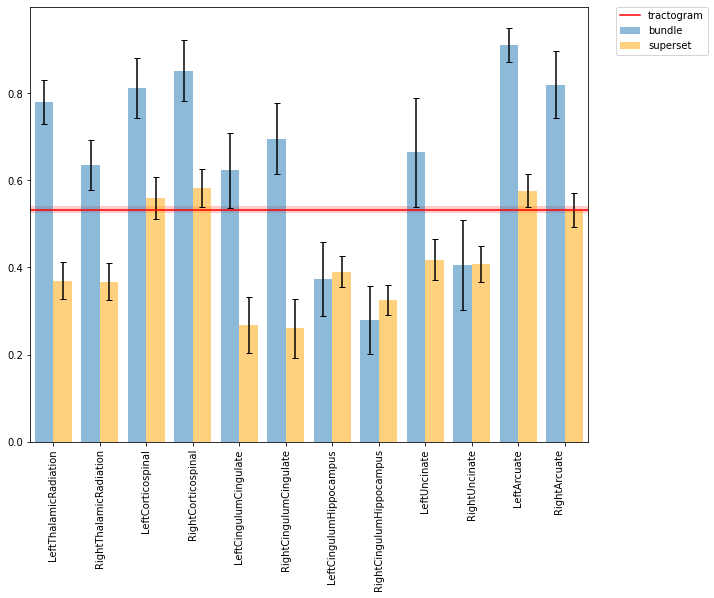

In [118]:
fig, ax = plt.subplots(figsize=(10,8))
gt_bar = ax.bar(X - 0.2, Y, yerr=Y_err, capsize=3, alpha=0.5, label='bundle', width=0.4)
ss_bar = ax.bar(X + 0.2 , Y2, yerr=Y2_err, capsize=3, alpha=0.5, color='orange', label='superset', width=0.4)
t_plot = ax.plot([-0.5, len(X)], [T_mu]*2, '-r', label='tractogram')
ax.fill_between([-0.5, len(X)], T_mu+T_std, T_mu-T_std, facecolor='r', alpha=0.2)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks, rotation=90)
ax.set_xlim(0-0.5,len(X)-0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

###### compute dsc

In [190]:
from dipy.tracking.vox2track import streamline_mapping
from dipy.tracking.utils import _mapping_to_voxel, _to_voxel_coordinates, subsegment

def dsc_vox(pred, gt, affine, resample=False):
    """Ratio of overlap between tract "pred" and gt tract (in voxels).
    """
    voxel_size = abs(affine[0,0])
    if resample:
        pred_streamlines = subsegment(pred,
                                max_segment_length=voxel_size/5)
        gt_streamlines = subsegment(gt,
                                max_segment_length=voxel_size/5) 
    else:
        pred_streamlines = pred
        gt_streamlines = gt
    voxel_list_pred = streamline_mapping(pred_streamlines, 
                                        affine=affine).keys()
    voxel_list_gt = streamline_mapping(gt_streamlines, 
                                        affine=affine).keys()
    tp = len(set(voxel_list_pred).intersection(set(voxel_list_gt)))
    vol_A = len(set(voxel_list_pred))
    vol_B = len(set(voxel_list_gt))
    dsc = 2.0 * float(tp) / float(vol_A + vol_B)

    return dsc

In [194]:
class_names = open('/home/pastolfi/datasets/multilap_dataset/afq_classes.txt').readlines()
class_names = [c.strip() for c in class_names]
row_hdr = ['Sub'] + class_names

table_dsc = []
table_dsc.append(row_hdr)

for i,s in enumerate(dataset.subjects):
    t0 = time()
    t_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16', 'sub-%s' % s)
    t_clean_dir = os.path.join('/home/pastolfi/datasets/multilap_dataset/derivatives/tract_MNI16CLEAN', 'sub-%s' % s)
    
    t_file = os.path.join(t_dir, 'sub-%s_tract_MNI16.trk' % (s))
    t, t_hdr, _, _ = ltrk.load_streamlines(t_file)
    
    row_dsc = [s]
    for c_name in class_names:
        fn = os.path.join(t_dir, 'sub-%s_%s_gt_idxsT.npy' % (s,c_name))
        fn_clean = os.path.join(t_clean_dir, 'sub-%s_%s_gt_clean_idxsT.npy' % (s,c_name))
        
        afq_idxs = np.load(fn)
        afq_clean_idxs = np.load(fn_clean)
        
        b = np.array(t)[afq_idxs]
        b_clean = np.array(t)[afq_clean_idxs]
        # compute dsc
        dsc = dsc_vox(b_clean, b, t_hdr['voxel_to_rasmm'], resample=True)
        
        # update table num streamlines
        row_dsc.append(round(dsc,4))

    table_dsc.append(row_dsc)
    with open('/home/pastolfi/datasets/multilap_dataset/table_dsc.csv', 'w') as f:
        f.writelines([','.join([str(i) for i in r]) + '\n' for r in table_dsc])

# plot DSC

In [74]:
lines = open('/home/pastolfi/datasets/multilap_dataset/table_dsc.csv', 'r').readlines()
x_ticks = lines[0].split(',')[1:]
# remove header row and col
mat_num = np.array([[float(x) for x in l.split(',')[1:]] for l in lines[1:]])

In [75]:
X = range(len(class_names))
Y = mat_num.mean(axis=0)
Y_err = mat_num.std(axis=0)

In [76]:
from matplotlib import pyplot as plt

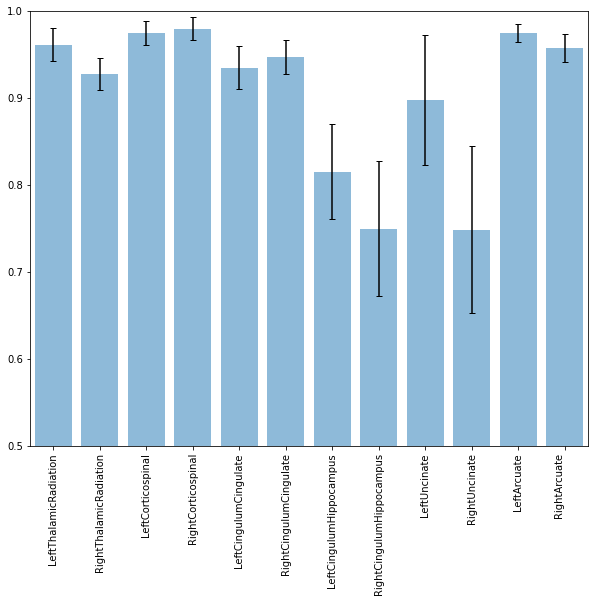

In [78]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(X,Y, yerr=Y_err, capsize=3, alpha=0.5)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks, rotation=90)
ax.set_xlim(0-0.5,len(X)-0.5)
ax.set_ylim(0.5,1)
plt.show()

In [189]:
row_dsc

['500222',
 0.9530683683900747,
 0.9334054969879518,
 0.98438708328979,
 0.9799454267142889,
 0.9295081551378637,
 0.9191260638033146,
 0.822805168875825,
 0.7983870967741935,
 0.9409944515578318,
 0.8524287863347406,
 0.9819651218748329,
 0.9675706993204096]

In [186]:
row_dsc

['500222',
 0.953314564640593,
 0.9346592220017534,
 0.9844633351215285,
 0.9802865028256013,
 0.9305387147063918,
 0.9201964693867626,
 0.8263246197975862,
 0.8008703360464179,
 0.9419696105377794,
 0.8546368291295278,
 0.9818361584036792,
 0.9676429053846626]

In [83]:
fn = glob.glob(os.path.join(t_dir, 'sub-%s_LeftArcuate*_gt_idxs.npy' % (s)))[0]
afq_idxs = np.load(fn)

In [84]:
t_out = nib.streamlines.Tractogram(np.array(t_sl)[afq_idxs].tolist(), affine_to_rasmm=np.eye(4))
nib.streamlines.save(t_out, '/home/pastolfi/datasets/multilap_dataset/sub-510225_LeftArcuateMNI16.trk', header=t_hdr)

In [81]:
torch.tensor(test_proba).squeeze()[idxs_nP].topk(250)[0][-1]

tensor(0.7953, dtype=torch.float64)

In [82]:
idxs_tmp = torch.tensor(test_proba).squeeze()[idxs_nP].topk(250)[1]
idxs_np_topk = idxs_nP[idxs_tmp]

In [43]:
torch.tensor(test_proba).squeeze()[idxs_nP].mean()

tensor(-0.3396, dtype=torch.float64)

In [101]:
idxs_P = np.where(test_preds[0]==1)[0]
idxs_nP = np.where(test_preds[0]==0)[0]

In [102]:
len(idxs_nP)

178131

In [83]:
t_old = nib.streamlines.load(fn)
t_clean = t_old.streamlines[idxs_P]
t_nP = t_old.streamlines[idxs_nP]
t_nP_topk = t_old.streamlines[idxs_np_topk]
# nib.streamlines.save(nib.streamlines.Tractogram(t_clean, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_CC_cleaned.trk', header=t_old.header)
nib.streamlines.save(nib.streamlines.Tractogram(t_nP_topk, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_AF_left_nP_MNI.trk', header=t_old.header)

In [84]:
t_old = nib.streamlines.load('/home/pietro/datasets/TractSeg_new/ground_truth_trk/sub-599469/sub-599469_var-GT_AF_left.trk')
t_clean = t_old.streamlines[idxs_P]
t_nP = t_old.streamlines[idxs_nP]
t_nP_topk = t_old.streamlines[idxs_np_topk]
# nib.streamlines.save(nib.streamlines.Tractogram(t_clean, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_CC_cleaned.trk', header=t_old.header)
nib.streamlines.save(nib.streamlines.Tractogram(t_nP_topk, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_AF_left_nP.trk', header=t_old.header)